In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Sample images from the training set:


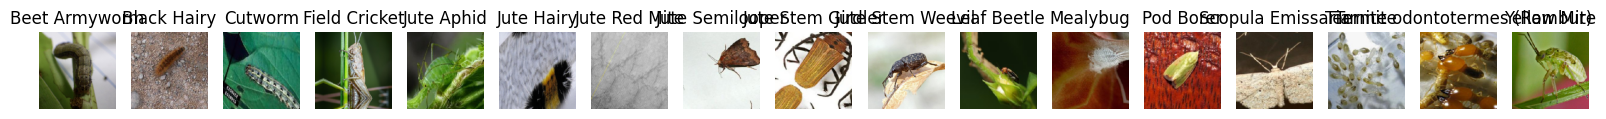

Sample images from the validation set:


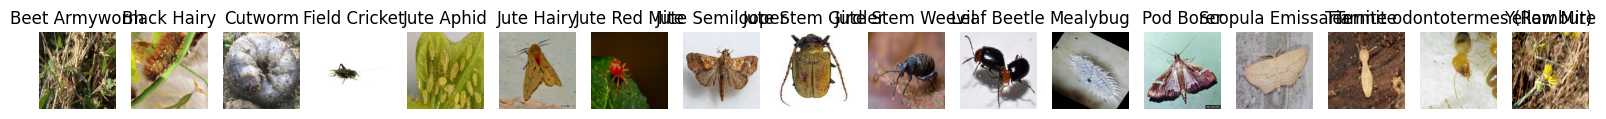

Sample images from the test set:


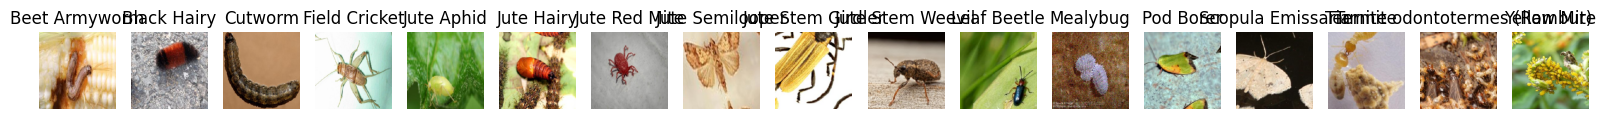

In [2]:

# Function to display one image per class from a given directory
def display_sample_images_from_directory(directory, img_size=(224, 224)):
    classes = sorted(os.listdir(directory))
    num_classes = len(classes)

    # Create a figure with subplots
    plt.figure(figsize=(20, num_classes))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        if image_files:
            # Load one image from the class directory
            img_path = os.path.join(class_dir, image_files[0])
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0

            # Plot the image
            plt.subplot(1, num_classes, i + 1)
            plt.imshow(img_array)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# File paths (replace with your actual dataset paths)
train_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/train'
val_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/val'
test_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/test'

# Display one image from each class in the training set
print("Sample images from the training set:")
display_sample_images_from_directory(train_dir)

# Display one image from each class in the validation set
print("Sample images from the validation set:")
display_sample_images_from_directory(val_dir)

# Display one image from each class in the test set
print("Sample images from the test set:")
display_sample_images_from_directory(test_dir)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Set input image size for MobileNetV2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for the validation and test set 
val_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

# Load data with flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 6443 images belonging to 17 classes.
Found 413 images belonging to 17 classes.
Found 379 images belonging to 17 classes.


In [5]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2

In [6]:
# Load MobileNetV2 pre-trained on ImageNet, excluding the top layers
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

# Freeze the base model to prevent updating its weights during training
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
from tensorflow.data import AUTOTUNE

In [8]:
import tensorflow as tf

In [9]:
# Detect and initialize GPU
try:
    # Check for GPU availability
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()  # Use MirroredStrategy for multi-GPU or single GPU
        print("Running on GPU")
    else:
        strategy = tf.distribute.get_strategy()  # Default strategy if GPU is not available
        print("Running on default strategy (CPU)")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy if GPU detection fails
    print("Running on default strategy (CPU)")

# Define model creation inside strategy scope for distributed training
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(17, activation='softmax')  # 17 classes in the dataset
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    checkpoint = ModelCheckpoint('mobilenetv2_best_model.keras',  # Updated to .keras
                                 monitor='val_loss',
                                 save_best_only=True,
                                 verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,  # You can adjust the number of epochs
        callbacks=[early_stopping, checkpoint]
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'Test accuracy: {test_acc:.4f}')

    # Save the final model
    model.save('mobilenetv2_final_model.keras')




Running on GPU
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.4478 - loss: 1.9087
Epoch 1: val_loss improved from inf to 0.84983, saving model to mobilenetv2_best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 138s 590ms/step - accuracy: 0.4487 - loss: 1.9055 - val_accuracy: 0.7101 - val_loss: 0.8498
Epoch 2/25
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8357 - loss: 0.5730
Epoch 2: val_loss improved from 0.84983 to 0.64889, saving model to mobilenetv2_best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 100s 478ms/step - accuracy: 0.8359 - loss: 0.5726 - val_accuracy: 0.8068 - val_loss: 0.6489
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8899 - loss: 0.4035
Epoch 3: val_loss did not improve from 0.64889
202/202 ━━━━━━━━━━━━━━━━━━━━ 99s 473ms/step - accuracy: 0.8900 - loss: 0.4033 - val_accuracy: 0.7874 - val_loss: 0.6901
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9103 - loss: 0.3310
Epoch 4: val_loss improved from 0.64889 to 0.49544, saving m